In [ ]:
!pip install bayesian-optimization

In [ ]:
!pip install shap

In [3]:
import numpy as np
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.model_selection import train_test_split ,GridSearchCV, KFold
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.inspection import permutation_importance
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot, PredictionError
from bayes_opt import BayesianOptimization, UtilityFunction
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
Paper1 = pd.read_excel('/content/data.xlsx',sheet_name='Paper1')
Paper2 = pd.read_excel('/content/data.xlsx',sheet_name='Paper2')
Paper1_2 = pd.read_excel('/content/data.xlsx',sheet_name='Paper1&2')
Full = pd.read_excel('/content/data.xlsx',sheet_name='Full')

In [5]:
def metrics():
  R2 = r2_score(y_test, model.predict(X_test))
  print("R2 Score(Test): {:.5f}".format(R2))
  R2 = r2_score(y_train, model.predict(X_train))
  print("R2 Score(Train): {:.5f}".format(R2))
  mse = mean_squared_error(y_test, model.predict(X_test))
  print("MSE(Test): {:.5f}".format(mse))
  mse = mean_squared_error(y_train, model.predict(X_train))
  print("MSE(Train): {:.5f}".format(mse))
  mae = mean_absolute_error(y_test, model.predict(X_test))
  print("MAE(Test): {:.5f}".format(mae))
  mae = mean_absolute_error(y_train, model.predict(X_train))
  print("MAE(Train): {:.5f}".format(mae))

In [6]:
def Feature_importance():
  feature_names = X.columns.tolist()
  FI = model.feature_importances_
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': FI})
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
  return feature_importance_df

#=======================================================================================================

def Permutation_importances_train(random_state):
  result = permutation_importance(
      model, X_train , y_train , random_state=random_state, n_jobs=2)
  sorted_importances_idx = result.importances_mean.argsort()
  importances = pd.DataFrame(
      result.importances[sorted_importances_idx].T,
      columns=X.columns[sorted_importances_idx],)
  ax = importances.plot.box(vert=False, whis=10)
  ax.set_title("Permutation Importances (train set)")
  ax.axvline(x=0, color="k", linestyle="--")
  ax.set_xlabel("Decrease")
  ax.figure.tight_layout()

#=======================================================================================================

def Permutation_importances_test(random_state):
  result = permutation_importance(
      model, X_test, y_test , random_state=random_state, n_jobs=2)
  sorted_importances_idx = result.importances_mean.argsort()
  importances = pd.DataFrame(
      result.importances[sorted_importances_idx].T,
      columns=X.columns[sorted_importances_idx],)
  ax = importances.plot.box(vert=False, whis=10)
  ax.set_title("Permutation Importances (test set)")
  ax.axvline(x=0, color="k", linestyle="--")
  ax.set_xlabel("Decrease")
  ax.figure.tight_layout()

#=======================================================================================================

def Select_From_model(model):
  selector = SelectFromModel(estimator=model).fit(X_train, y_train)
  selected_feature_indices = selector.get_support()
  selected_feature_names = [feature_name for feature_name, selected in zip(X.columns, selected_feature_indices) if selected]
  threshold = selector.threshold_
  print('selector_threshold:',threshold)
  return selected_feature_names
#=======================================================================================================

def Recursive_Feature_Elimination(model):
  selector = RFE(estimator=model, n_features_to_select=1, step=1)
  selector = selector.fit(X_train, y_train)
  selected_feature = selector.support_
  selected_feature_names = [feature_name for feature_name, selected in zip(X.columns, selected_feature) if selected]
  features = X_train.columns.to_list()
  for x, y in (sorted(zip(selector .ranking_ , features), key=itemgetter(0))):
    print(x, y)

#=======================================================================================================

def Shap():
  explainer = shap.Explainer(model)
  shap_values = explainer.shap_values(X)
  return shap.summary_plot(shap_values, X)



---



**XRD_Paper1**

In [ ]:
#delta(efficiency,9.3), Paper1
#Paper1 = pd.read_excel('/content/data.xlsx',sheet_name='Paper1')
#Paper1 = Paper1.drop(columns=['delta(eff,12)','delta(eff)'])
#X = Paper1.drop('delta(eff,9.3)', axis=1)
#y = Paper1['delta(eff,9.3)']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
#=========================
# Lasso Regression
#model = Lasso(alpha=0.0125)
#model.fit(X_train, y_train)
#features = X.columns
#model_coef = np.abs(model.coef_)
#feature_subset=np.array(features)[model_coef> 0]
#print("Selected Features : {}".format(feature_subset))
#=========================
#XGBoost Regressor
#model= XGBRegressor(n_estimators=594, reg_lambda=0.8328,learning_rate=0.09247 ,alpha=0.07387)
#model.fit(X_train, y_train);
#=========================
#Gradient Boosting Regressor
#model = GradientBoostingRegressor(n_estimators=420, learning_rate=0.021,subsample=0.9688,min_samples_split=8,random_state=78)
#model.fit(X_train, y_train);
#===============================================================================
#delta(efficiency,12), Paper1
#Paper1 = pd.read_excel('/content/data.xlsx',sheet_name='Paper1')
#Paper1 = Paper1.drop(columns=['delta(eff,9.3)','delta(eff)'])
#X = Paper1.drop('delta(eff,12)', axis=1)
#y = Paper1['delta(eff,12)']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
#=========================
#XGBoost Regressor
#model= XGBRegressor(n_estimators=594, reg_lambda=0.8328,learning_rate=0.09239 ,alpha=0.07387)
#model.fit(X_train, y_train);
#=========================
#Gradient Boosting Regressor
#model = GradientBoostingRegressor(n_estimators=420, learning_rate=0.016, max_depth=7,subsample=0.9688,min_samples_split=8)
#model.fit(X_train, y_train);



---



---



In [7]:
#delta(efficiency), Paper1 , XRD
Paper1 = pd.read_excel('/content/data.xlsx',sheet_name='Paper1')
Paper1 = Paper1.drop(columns=['delta(eff,9.3)','delta(eff,12)'])
X = Paper1.drop('delta(eff)', axis=1)
y = Paper1['delta(eff)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

In [ ]:
#Optimization_XGBoost Regressor
def objective(learning_rate,n_estimators,reg_lambda,alpha):
    model = XGBRegressor(learning_rate=learning_rate,
                         n_estimators=int(n_estimators),
                         reg_lambda = reg_lambda,
                         alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)
#===============================================================================
pbounds = {
    'learning_rate': (0.02, 0.045),
    'n_estimators': (400, 700),
    'reg_lambda' : (0.1,1),
    'alpha': (0,0.8)
}
#===============================================================================
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=78,
)

optimizer.maximize(
    init_points=5,
    n_iter=30,
)

In [8]:
#XGBoost Regressor
model= XGBRegressor(n_estimators=639, reg_lambda=0.9345 ,learning_rate=0.04002  ,alpha=0.02792)
model.fit(X_train, y_train);
metrics()

R2 Score(Test): 0.95905
R2 Score(Train): 0.96943
MSE(Test): 0.02067
MSE(Train): 0.01450
MAE(Test): 0.10566
MAE(Train): 0.06733


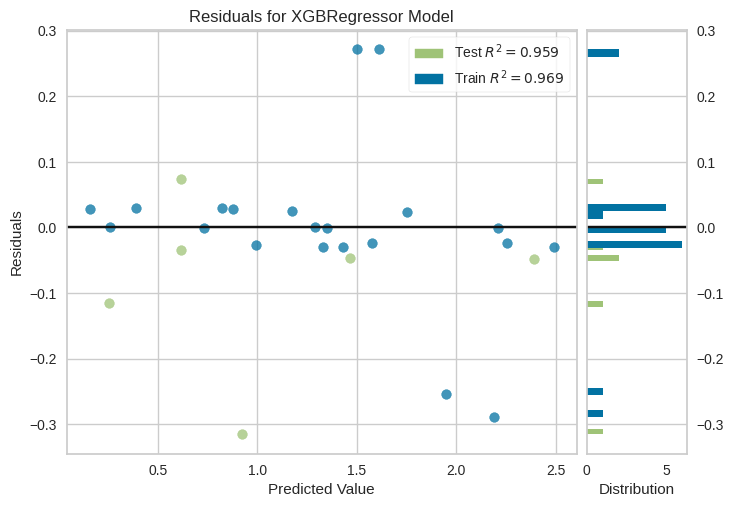

<Axes: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [9]:
visualizer = ResidualsPlot(model)
visualizer.score(X_test, y_test)
visualizer.fit(X_train, y_train)
visualizer.show()

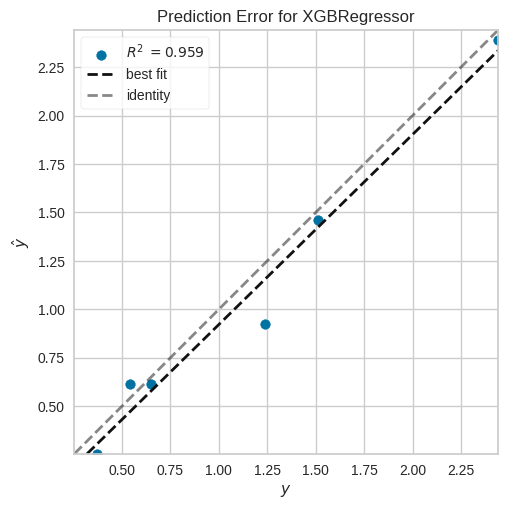

<Axes: title={'center': 'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [23]:
visualizer = PredictionError(model,alpha=1)
visualizer.score(X_test, y_test)
visualizer.fit(X_train, y_train)
visualizer.show()

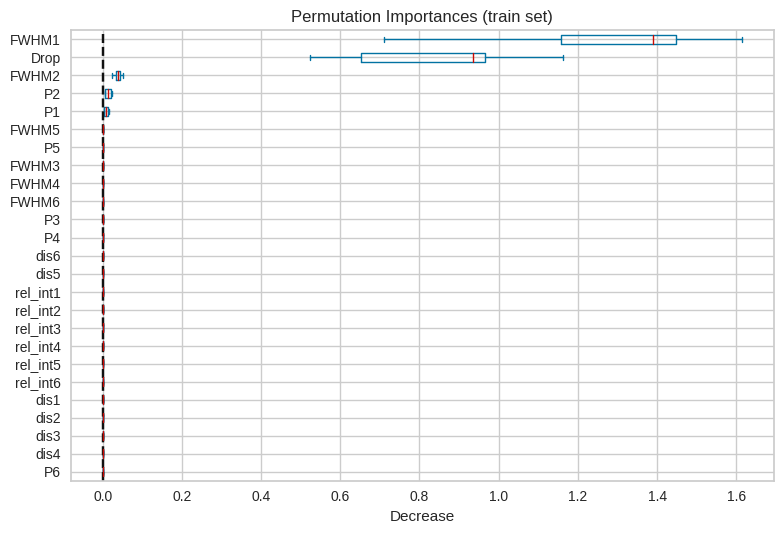

In [10]:
Permutation_importances_train(78)

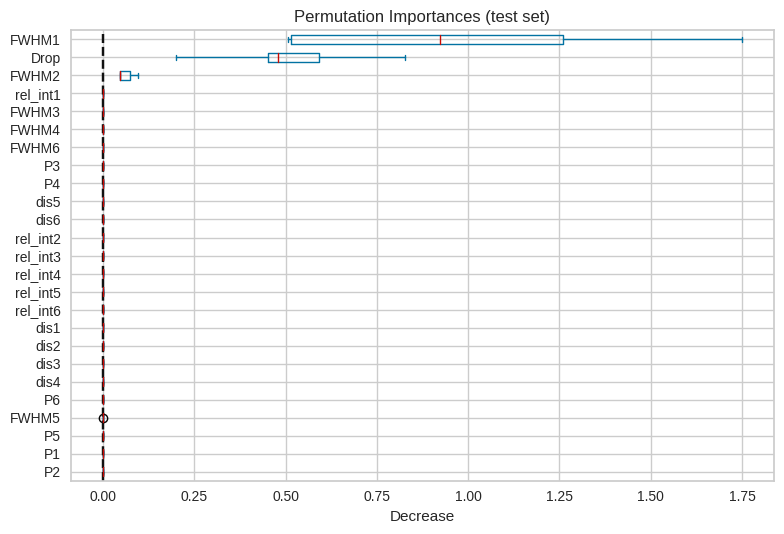

In [11]:
Permutation_importances_test(78)

In [12]:
Select_From_model(model)

selector_threshold: 0.04


['Drop', 'FWHM1', 'P2']

In [13]:
Feature_importance()

,Feature,Importance
1,FWHM1,0.485642
8,P2,0.425310
0,Drop,0.074265
2,FWHM2,0.012252
11,P5,0.001875
7,P1,0.000640
5,FWHM5,0.000016
16,rel_int4,0.000000
23,dis5,0.000000
22,dis4,0.000000


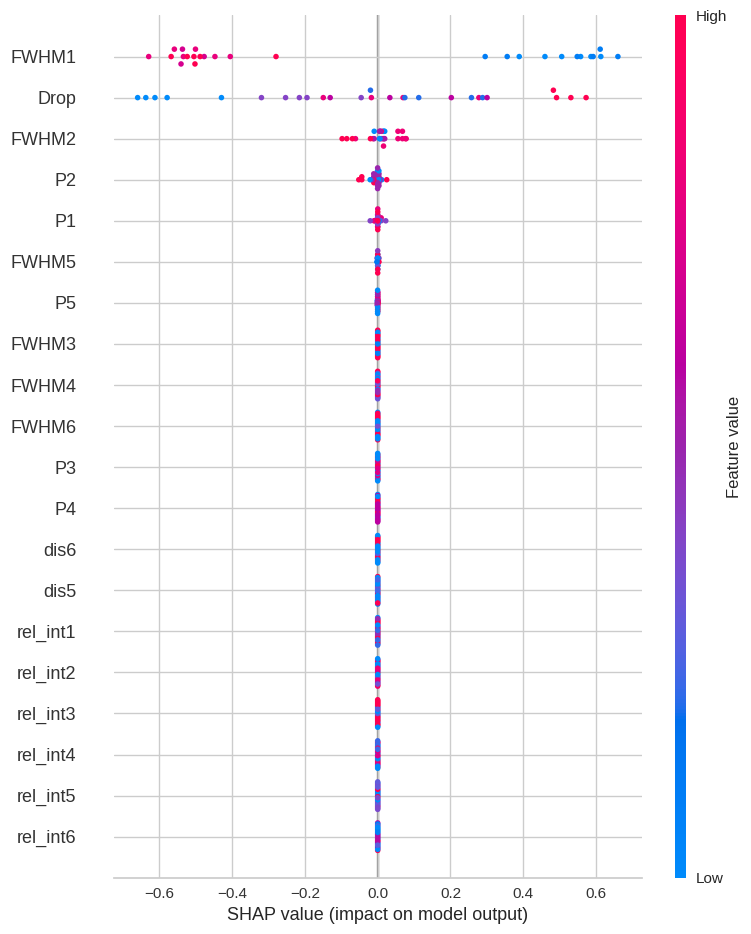

In [14]:
Shap()

In [ ]:
#Optimization_Gradient Boosting Regressor
def objective(learning_rate, n_estimators, max_depth, subsample,min_samples_split):
    model = GradientBoostingRegressor(learning_rate=learning_rate,
                         n_estimators=int(n_estimators),
                         max_depth=int(max_depth),
                         subsample=subsample,
                         min_samples_split=int(min_samples_split))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)
#===============================================================================
pbounds = {
    'learning_rate': (0.01, 0.05),
    'n_estimators': (300, 500),
    'max_depth': (7, 10),
    'subsample': (0.7, 1.0),
    'min_samples_split' : (7,10)
}
#===============================================================================
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=78,
)

optimizer.maximize(
    init_points=5,
    n_iter=30,
)

In [15]:
#Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=321, learning_rate= 0.03232  ,subsample=0.9859,min_samples_split=9,random_state=78)
model.fit(X_train, y_train);
metrics()

R2 Score(Test): 0.91221
R2 Score(Train): 0.91566
MSE(Test): 0.04431
MSE(Train): 0.04002
MAE(Test): 0.18430
MAE(Train): 0.15715


In [16]:
Select_From_model(model)

selector_threshold: 0.04


['Drop', 'FWHM1', 'FWHM2', 'FWHM4', 'rel_int1', 'rel_int3', 'rel_int6', 'dis3']

In [17]:
Feature_importance()

,Feature,Importance
0,Drop,0.401176
13,rel_int1,0.084776
15,rel_int3,0.059219
4,FWHM4,0.054823
18,rel_int6,0.054816
1,FWHM1,0.049367
21,dis3,0.042987
2,FWHM2,0.040934
22,dis4,0.038053
19,dis1,0.037812


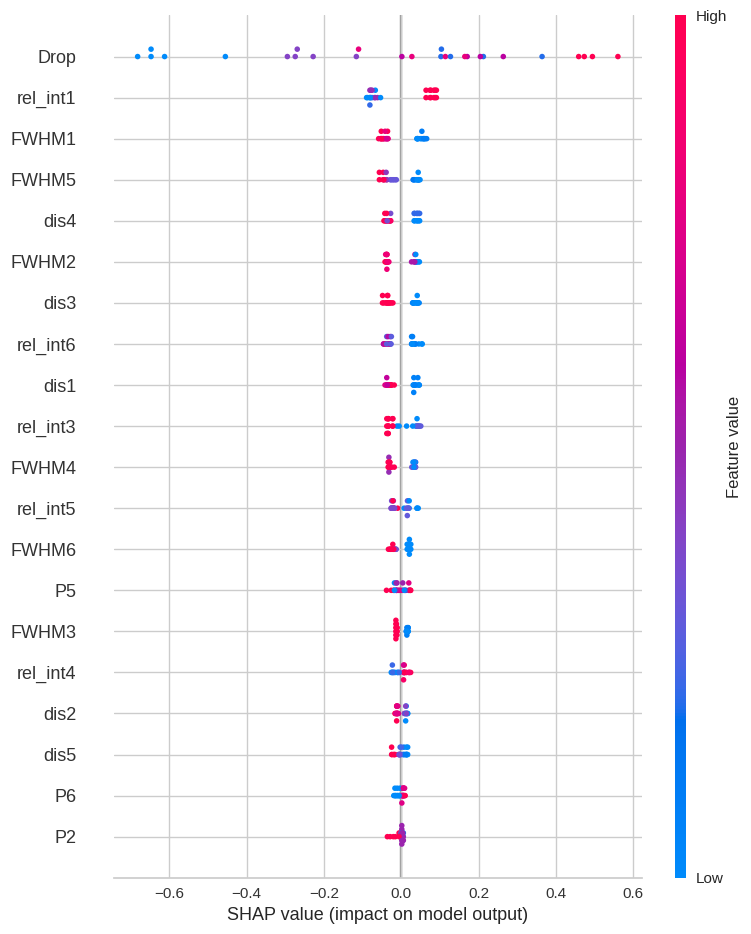

In [18]:
Shap()



---



**XRD_Paper2**

In [ ]:
## delta(efficiency,9.3), Paper2
#Paper2 = pd.read_excel('/content/data_XRD.xlsx',sheet_name='Paper2')
#Paper2 = Paper2.drop(columns=['delta(eff,12)','delta(eff)'])
#X = Paper2.drop('delta(eff,9.3)', axis=1)
#y = Paper2['delta(eff,9.3)']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
#=========================
## XGBoost Regressor
#model= XGBRegressor(n_estimators=594, reg_lambda=0.9497 ,learning_rate=0.5,alpha=0.05633)
#model.fit(X_train, y_train);
#=========================
## Gradient Boosting Regressor
#model = GradientBoostingRegressor(n_estimators=420, learning_rate=0.016, max_depth=7,subsample=0.9688,min_samples_split=8)
#model.fit(X_train, y_train);
#===============================================================================
## delta(efficiency,12), Paper2
#Paper2 = pd.read_excel('/content/data.xlsx',sheet_name='Paper2')
#Paper2 = Paper2.drop(columns=['delta(eff,9.3)','delta(eff)'])
#X = Paper2.drop('delta(eff,12)', axis=1)
#y = Paper2['delta(eff,12)']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)
#=========================
## XGBoost Regressor
#model= XGBRegressor(n_estimators=594, reg_lambda=0.9497 ,learning_rate=0.5,alpha=0.05633)
#model.fit(X_train, y_train);
#=========================
## Gradient Boosting Regressor
#model = GradientBoostingRegressor(n_estimators=420, learning_rate=0.017, max_depth=7,subsample=0.9688,min_samples_split=8)
#model.fit(X_train, y_train);



---



---



In [19]:
#delta(efficiency), Paper2 , XRD
Paper2 = pd.read_excel('/content/data.xlsx',sheet_name='Paper2')
Paper2 = Paper2.drop(columns=['delta(eff,9.3)','delta(eff,12)'])
X = Paper2.drop('delta(eff)', axis=1)
y = Paper2['delta(eff)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=78)

In [20]:
#XGBoost Regressor
model= XGBRegressor(n_estimators=594, reg_lambda=0.9497 ,learning_rate=0.81,alpha=0.05633)
model.fit(X_train, y_train);
metrics()

R2 Score(Test): 0.96382
R2 Score(Train): 0.99875
MSE(Test): 0.06749
MSE(Train): 0.00184
MAE(Test): 0.24335
MAE(Train): 0.03807


In [21]:
Select_From_model(model)

selector_threshold: 0.039999995


['Drop', 'FWHM3', 'rel_int1']

In [22]:
Recursive_Feature_Elimination(model)

1 FWHM3
2 Drop
3 rel_int1
4 FWHM4
5 FWHM5
6 rel_int5
7 dis2
8 dis1
9 rel_int6
10 rel_int4
11 rel_int3
12 rel_int2
13 P1
14 FWHM6
15 FWHM2
16 FWHM1
17 dis3
18 P2
19 dis4
20 P3
21 dis5
22 P4
23 dis6
24 P5
25 P6


In [23]:
Feature_importance()

,Feature,Importance
3,FWHM3,0.433547
13,rel_int1,0.357144
0,Drop,0.174377
4,FWHM4,0.027767
5,FWHM5,0.004978
17,rel_int5,0.002187
15,rel_int3,0.000000
23,dis5,0.000000
22,dis4,0.000000
21,dis3,0.000000


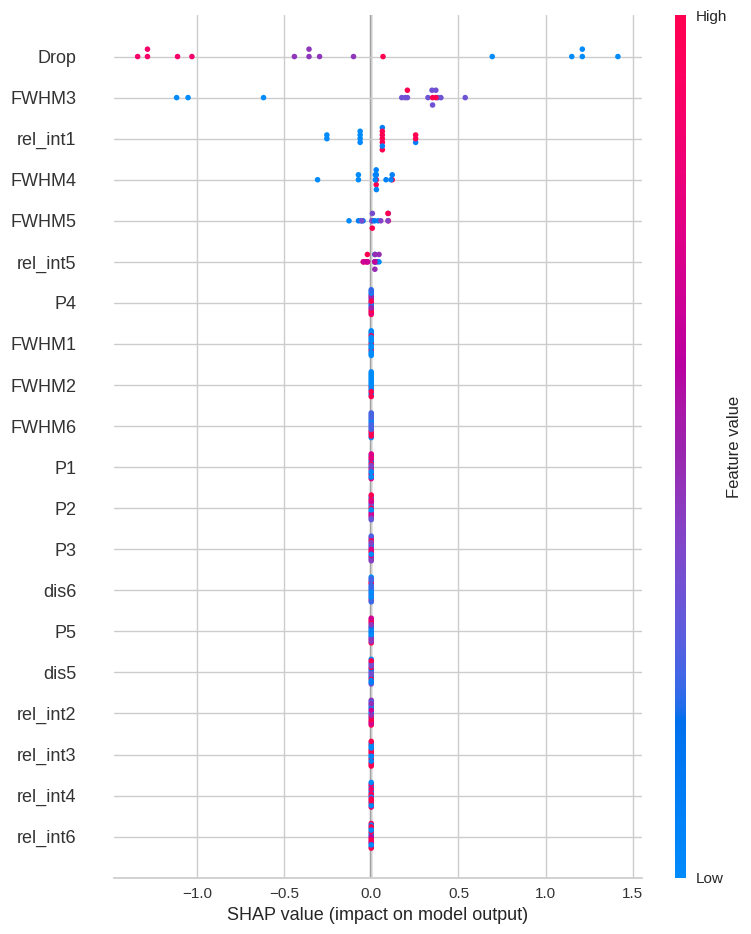

In [24]:
Shap()

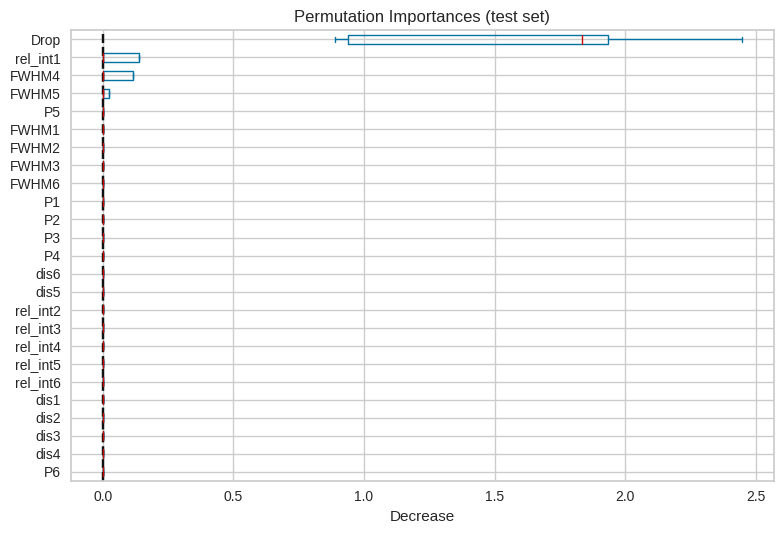

In [27]:
Permutation_importances_test(78)

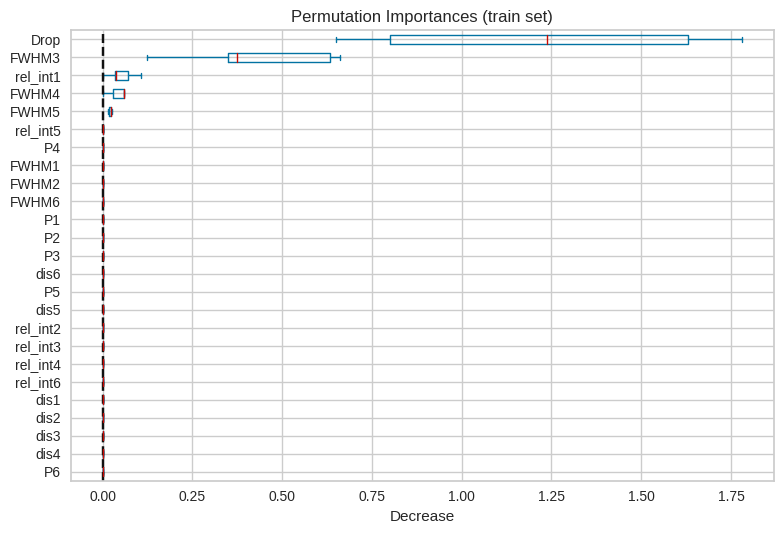

In [28]:
Permutation_importances_train(78)

In [29]:
#Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=445, learning_rate=0.018,subsample=0.9688,min_samples_split=10,random_state=78)
model.fit(X_train, y_train);
metrics()

R2 Score(Test): 0.91901
R2 Score(Train): 0.92774
MSE(Test): 0.15106
MSE(Train): 0.10674
MAE(Test): 0.32809
MAE(Train): 0.26830


In [30]:
Feature_importance()

,Feature,Importance
0,Drop,0.617974
22,dis4,0.049299
13,rel_int1,0.049023
12,P6,0.046826
17,rel_int5,0.045133
9,P3,0.032588
7,P1,0.032136
19,dis1,0.022952
21,dis3,0.022236
8,P2,0.016139


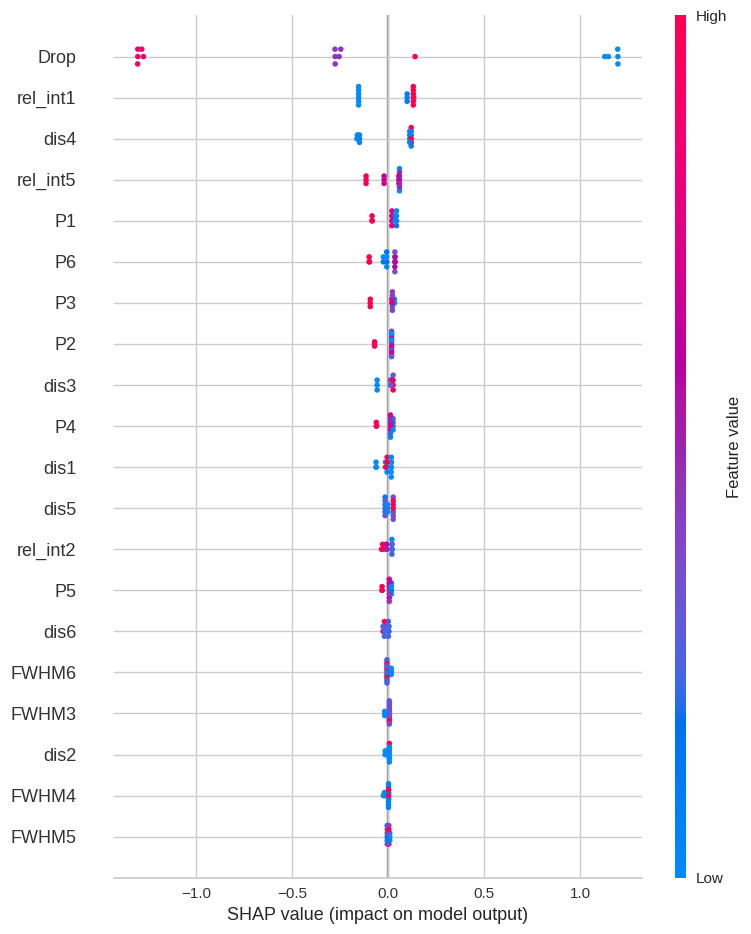

In [31]:
Shap()

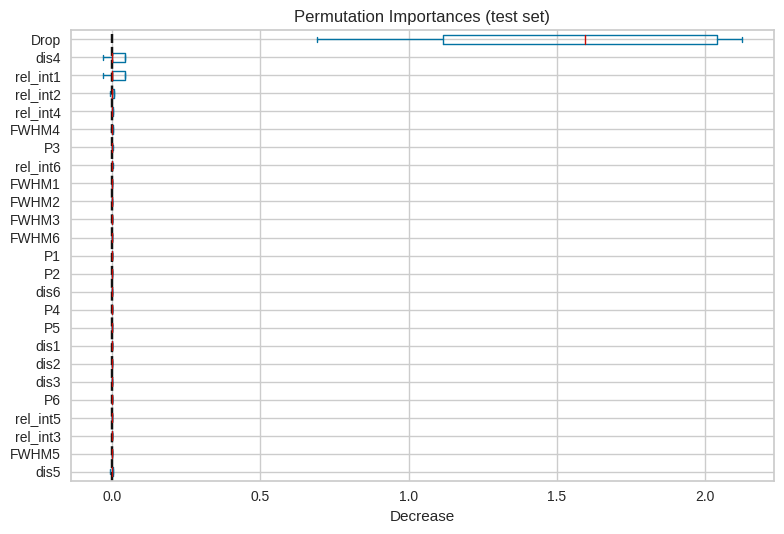

In [32]:
Permutation_importances_test(78)

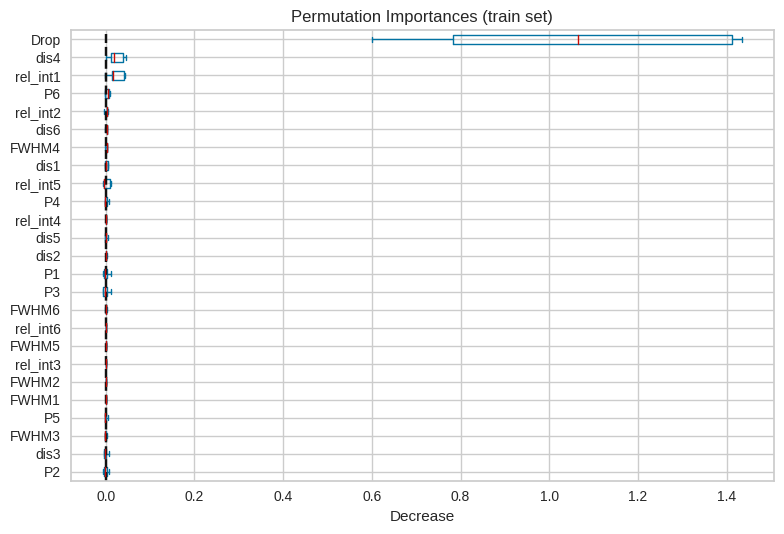

In [33]:
Permutation_importances_train(78)

In [34]:
Select_From_model(model)

selector_threshold: 0.04


['Drop', 'P6', 'rel_int1', 'rel_int5', 'dis4']



---



**XRD_Paper1&2**

In [ ]:
## delta(efficiency,9.3), Paper1&2
#Paper1_2 = pd.read_excel('/content/data.xlsx',sheet_name='Paper1&2')
#Paper1_2 = Paper1_2.drop(columns=['delta(eff,12)','delta(eff)'])
#X = Paper1_2.drop('delta(eff,9.3)', axis=1)
#y = Paper1_2['delta(eff,9.3)']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#=========================
## XGBoost Regressor
#model= XGBRegressor(alpha=0.111 ,subsample=0.1191 ,reg_lambda= 0.1755 ,n_estimators=420,max_depth=9,learning_rate=0.4985)
#model.fit(X_train, y_train);
#===============================================================================
## delta(efficiency,12), Paper1&2
#Paper1_2 = pd.read_excel('/content/data.xlsx',sheet_name='Paper1&2')
#Paper1_2 = Paper1_2.drop(columns=['delta(eff,9.3)','delta(eff)'])
#X = Paper1_2.drop('delta(eff,12)', axis=1)
#y = Paper1_2['delta(eff,12)']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#=========================
## XGBoost Regressor
#model= XGBRegressor(alpha=0.1059 ,subsample=0.1171 ,reg_lambda= 0.1521 ,n_estimators=405,max_depth=8,learning_rate=0.4676)
#model.fit(X_train, y_train);



---



---



In [35]:
#delta(efficiency), Paper1&2 , XRD
Paper1_2 = pd.read_excel('/content/data.xlsx',sheet_name='Paper1&2')
Paper1_2 = Paper1_2.drop(columns=['delta(eff,9.3)','delta(eff,12)'])
X = Paper1_2.drop('delta(eff)', axis=1)
y = Paper1_2['delta(eff)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Optimization_XGBoost Regressor
def objective(alpha,reg_lambda,max_depth,n_estimators,subsample,learnnig_rate):
    model = XGBRegressor(alpha=alpha,
                         reg_lambda=reg_lambda,
                         max_depth=int(max_depth),
                         n_estimators=int(n_estimators),
                         subsample = subsample,
                         learning_rate=learnnig_rate)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)
#===============================================================================
pbounds = {
    'alpha' : (0.1, 0.15),
    'reg_lambda' : (0.151, 0.153),
    'max_depth' : (8,8),
    'n_estimators' : (405,405),
    'subsample' : (0.11,0.13),
    'learnnig_rate' : (0.45,0.5)
}
#===============================================================================
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(
    init_points=5,
    n_iter=30,
)

In [36]:
#XGBoost Regressor
model= XGBRegressor(alpha=0.1404 ,subsample=0.1137,reg_lambda= 0.1521 ,n_estimators=268,learning_rate=0.489)
model.fit(X_train, y_train);
metrics()

R2 Score(Test): 0.95068
R2 Score(Train): 0.95530
MSE(Test): 0.08832
MSE(Train): 0.04090
MAE(Test): 0.25352
MAE(Train): 0.13720


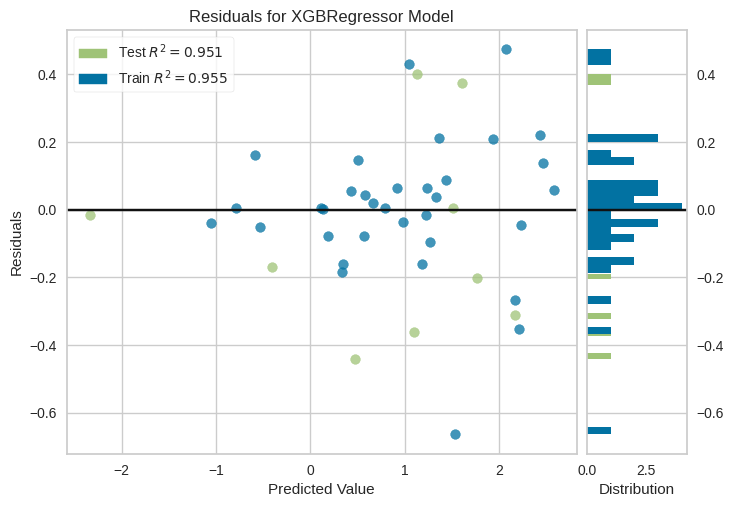

<Axes: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [37]:
visualizer = ResidualsPlot(model)
visualizer.score(X_test, y_test)
visualizer.fit(X_train, y_train)
visualizer.show()

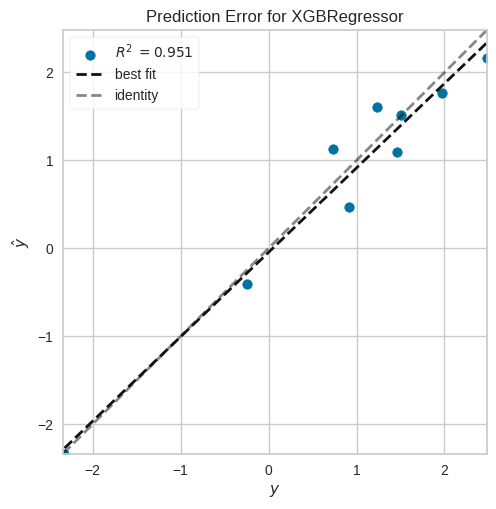

<Axes: title={'center': 'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [38]:
visualizer = PredictionError(model,alpha=1)
visualizer.score(X_test, y_test)
visualizer.fit(X_train, y_train)
visualizer.show()

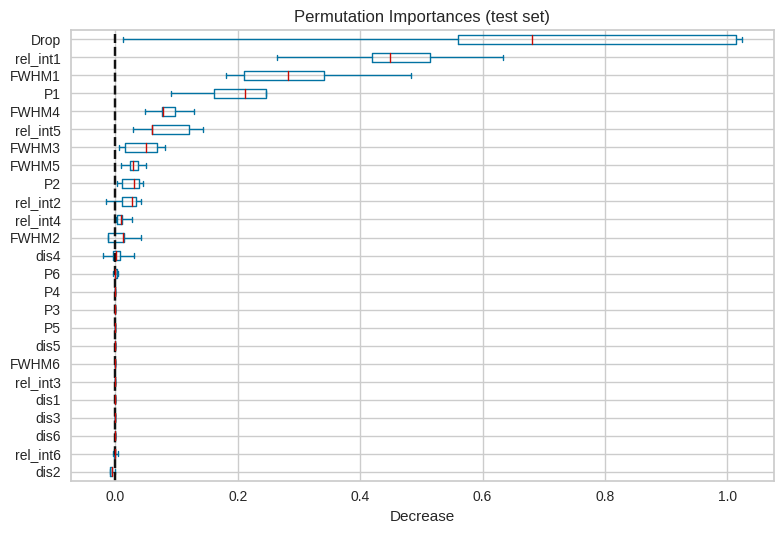

In [39]:
Permutation_importances_test(42)

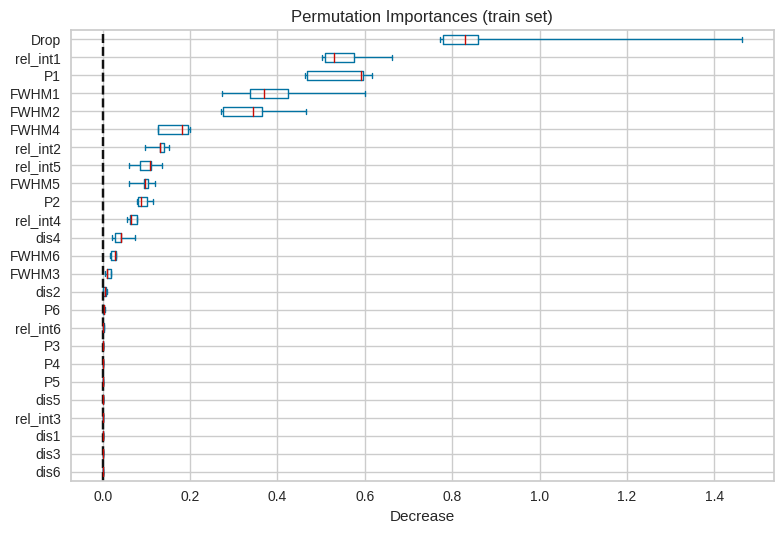

In [40]:
Permutation_importances_train(42)

In [41]:
Select_From_model(model)

selector_threshold: 0.04


['FWHM4', 'P1', 'rel_int1', 'rel_int2', 'rel_int5', 'dis4']

In [42]:
Feature_importance()

,Feature,Importance
17,rel_int5,0.463983
7,P1,0.106790
4,FWHM4,0.077019
22,dis4,0.068282
14,rel_int2,0.067585
13,rel_int1,0.059804
1,FWHM1,0.028481
8,P2,0.026945
5,FWHM5,0.021814
0,Drop,0.019604


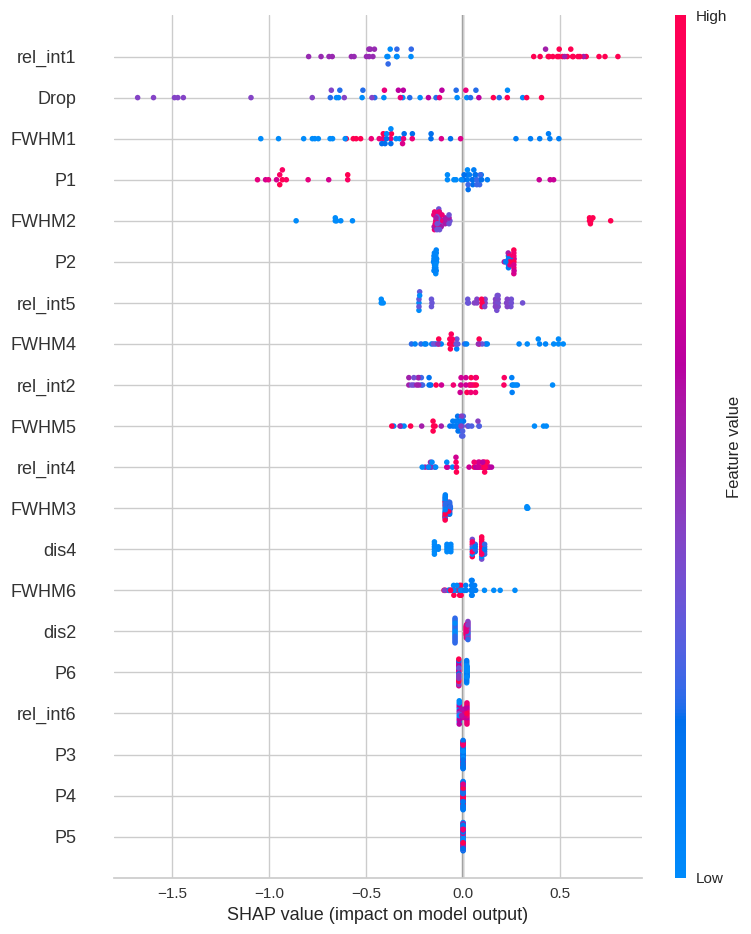

In [43]:
Shap()

In [44]:
Recursive_Feature_Elimination(model)

1 rel_int5
2 rel_int2
3 P1
4 rel_int1
5 FWHM4
6 FWHM1
7 rel_int4
8 P2
9 Drop
10 FWHM2
11 FWHM5
12 dis4
13 FWHM3
14 FWHM6
15 P6
16 dis2
17 rel_int6
18 dis3
19 rel_int3
20 P3
21 dis1
22 P4
23 dis5
24 P5
25 dis6




---


**PL&XRD_Paper1&2**

In [ ]:
## delta(efficiency,9.3), Paper1&2 , PL&XRD
#Full = pd.read_excel('/content/data.xlsx',sheet_name='Full')
#Full = Full.drop(columns=['delta(eff,12)','delta(eff)'])
#X = Full.drop('delta(eff,9.3)', axis=1)
#y = Full['delta(eff,9.3)']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#=========================
## XGBoost Regressor
#model= XGBRegressor(alpha=0.1058 ,subsample=0.1172 ,reg_lambda= 0.1586 ,n_estimators=280,learning_rate=0.3366)
#model.fit(X_train, y_train);
#===============================================================================




---



---



In [45]:
#delta(efficiency), Paper1&2 , PL&XRD
Full = pd.read_excel('/content/data.xlsx',sheet_name='Full')
Full = Full.drop(columns=['delta(eff,12)','delta(eff,9.3)'])
X = Full.drop('delta(eff)', axis=1)
y = Full['delta(eff)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
#XGBoost Regressor
model= XGBRegressor(alpha=0.1489 ,subsample=0.1154,reg_lambda= 0.1514 ,n_estimators=268,learning_rate=0.49692)
model.fit(X_train, y_train);
metrics()

R2 Score(Test): 0.95860
R2 Score(Train): 0.96010
MSE(Test): 0.07414
MSE(Train): 0.03651
MAE(Test): 0.20891
MAE(Train): 0.14316


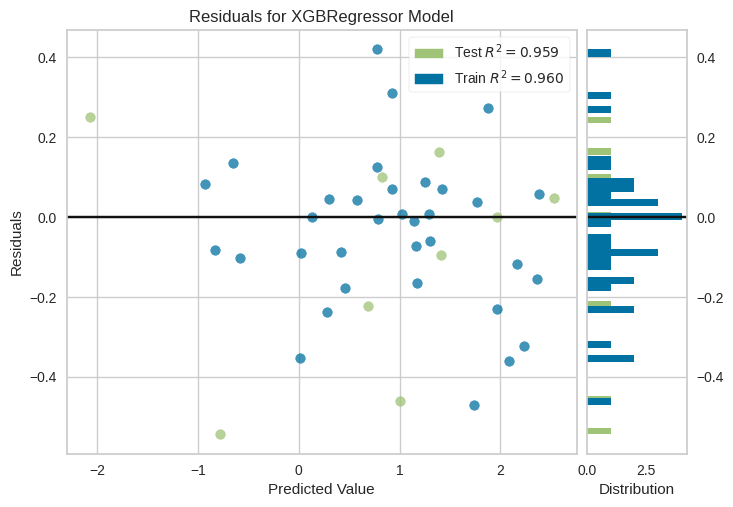

<Axes: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [47]:
visualizer = ResidualsPlot(model)
visualizer.score(X_test, y_test)
visualizer.fit(X_train, y_train)
visualizer.show()

In [48]:
Feature_importance()

,Feature,Importance
17,rel_int5,0.202326
4,FWHM4,0.096450
7,P1,0.082280
28,PL_peak_positions_2,0.080874
14,rel_int2,0.078756
18,rel_int6,0.072479
13,rel_int1,0.064489
15,rel_int3,0.050173
26,PL_fwhm_2,0.039510
6,FWHM6,0.026873


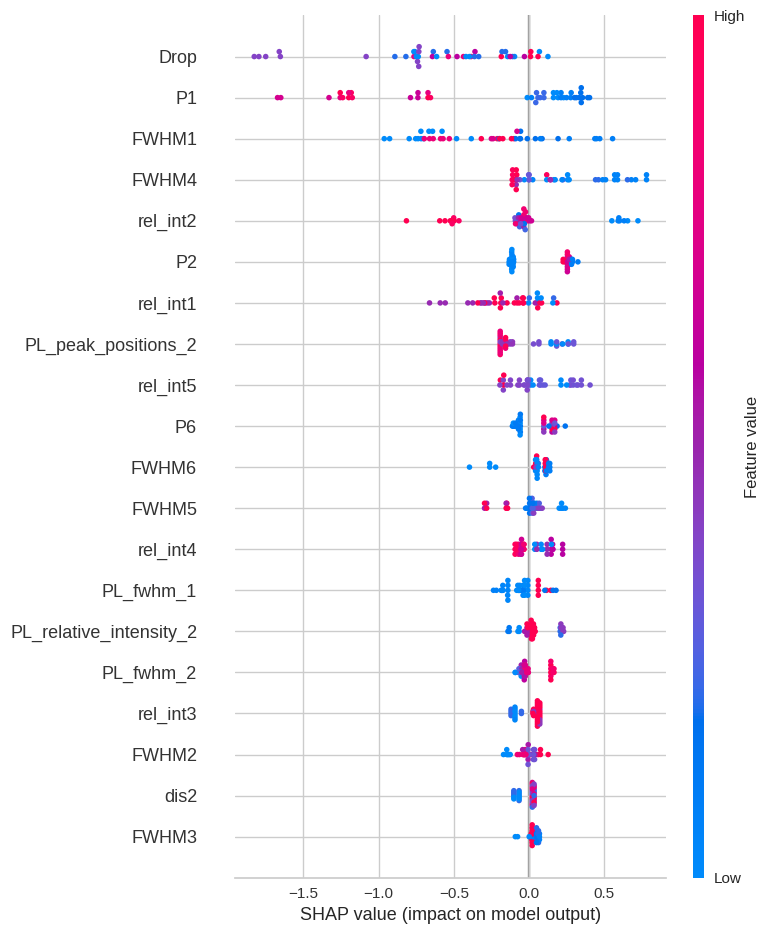

In [49]:
Shap()

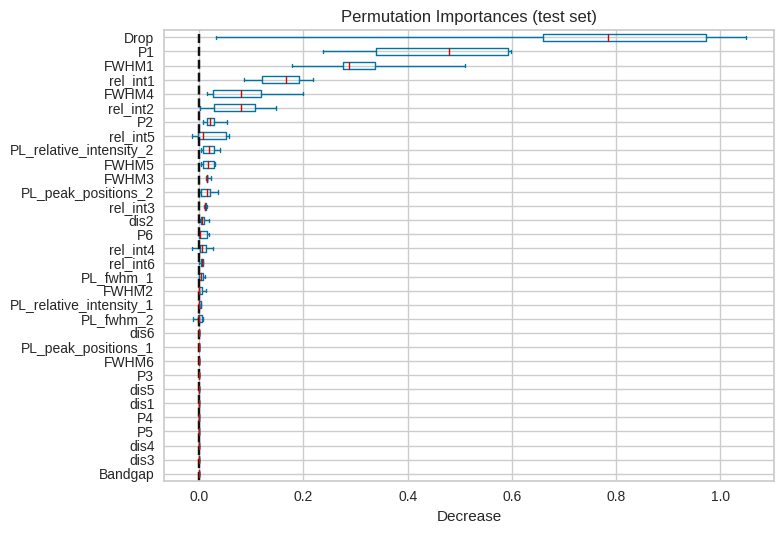

In [50]:
Permutation_importances_test(42)

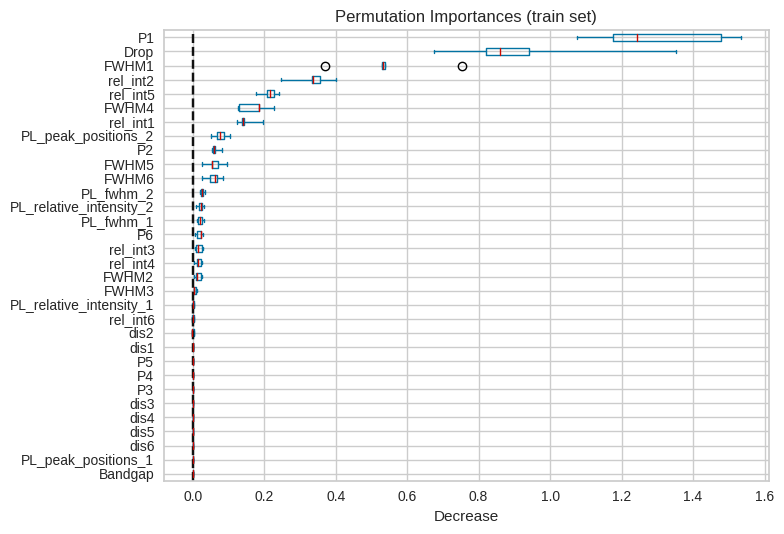

In [51]:
Permutation_importances_train(42)